In [3]:
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;
import mysql.connector

db = mysql.connector.connect(
    host= "localhost",
    username = "root",
    password = "Abhilash#07",
    database = "project_target"
)

cur = db.cursor()


****Basic : Queries****

1. List all unique cities where customers are located.

In [24]:
query = """ select distinct customer_city from customers; """

cur.execute(query)
data = cur.fetchall()
data[0:11]

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',)]

2. Count the number of orders placed in 2017.

In [5]:
query = """ SELECT count(order_id) FROM orders WHERE year(order_purchase_timestamp) = 2017; """

cur.execute(query)
data = cur.fetchall()
data



[(45101,)]

3. Find the total sales per category.

In [6]:
query = """ SELECT ROUND(sum(p.payment_value),2) as sales, lower(pd.product_category) category
FROM order_items oi
JOIN payments p
ON oi.order_id = p.order_id
JOIN products pd
ON oi.product_id = pd.product_id
GROUP BY pd.product_category
ORDER BY sales desc; """

cur.execute(query) 
data = cur.fetchall()

sales_per_category = pd.DataFrame(data, columns=['Category', 'Sales'])
sales_per_category

,Category,Sales
0,1712553.67,bed table bath
1,1657373.12,health beauty
2,1585330.45,computer accessories
3,1430176.39,furniture decoration
4,1429216.68,watches present
...,...,...
69,2174.43,pc gamer
70,1710.54,house comfort 2
71,1199.43,cds music dvds
72,785.67,fashion children's clothing


4. Calculate the percentage of orders that were paid in installments.


In [7]:
query = """ SELECT sum(
	CASE when payment_installments >=1 then 1
	ELSE 0
END
) / COUNT(*) * 100 as percentage_of_orders
FROM payments
; """

cur.execute(query) 
data = cur.fetchall()
round(data[0][0],4)


Decimal('99.9981')

5. Count the number of customers from each state. 


In [8]:
query = """ SELECT 
    customer_state state,
	COUNT(customer_unique_id) as no_of_customers
FROM customers
GROUP BY 1
ORDER BY 2 DESC
; """

cur.execute(query) 
data = cur.fetchall()

customer_per_state = pd.DataFrame(data, columns=['Category', 'Sales'])
customer_per_state

,Category,Sales
0,SP,83492
1,RJ,25704
2,MG,23270
3,RS,10932
4,PR,10090
5,SC,7274
6,BA,6760
7,DF,4280
8,ES,4066
9,GO,4040


****Intermediate : Queries****

1. Calculate the number of orders per month in 2018.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October')])

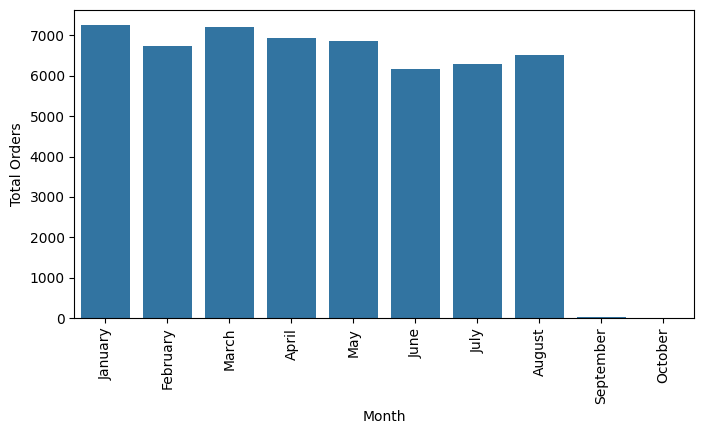

In [9]:
query = """ SELECT 
	date_format(order_purchase_timestamp, '%M') as month,
	count(order_id) as total_orders,
    MONTH(order_purchase_timestamp) AS month_number 
FROM orders
WHERE year(order_purchase_timestamp) = 2018
GROUP BY 1,3
ORDER BY 3 ASC;
"""

cur.execute(query) 
data = cur.fetchall()

order_per_month_2018 = pd.DataFrame(data, columns=['Month_name', 'Orders','Month'])
order_per_month_2018


plt.figure(figsize=(8,4))
sns.barplot(x=order_per_month_2018['Month_name'], y=order_per_month_2018['Orders'])

plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.xticks(rotation =90)


3. Calculate the percentage of total revenue contributed by each product category.


In [10]:
query = """ WITH percentage_by_product AS
(
SELECT lower(pd.product_category ) as category, sum(p.payment_value) as total_revenue
FROM payments p
JOIN order_items oi
ON p.order_id = oi.order_id
JOIN products pd
ON oi.product_id = pd.product_id
GROUP BY 1
ORDER BY 2 DESC
) 
SELECT 
	category,
    round(total_revenue,2),
    ROUND((total_revenue/SUM(total_revenue) OVER()) * 100 ,2) as percentage
FROM percentage_by_product
ORDER BY 3 DESC
; """

cur.execute(query) 
data = cur.fetchall()

revenue_per_product = pd.DataFrame(data, columns=['Category', 'Total revenue','Percentage'])
revenue_per_product


,Category,Total revenue,Percentage
0,bed table bath,1712553.67,8.43
1,health beauty,1657373.12,8.16
2,computer accessories,1585330.45,7.81
3,furniture decoration,1430176.39,7.04
4,watches present,1429216.68,7.04
...,...,...,...
69,pc gamer,2174.43,0.01
70,house comfort 2,1710.54,0.01
71,cds music dvds,1199.43,0.01
72,fashion children's clothing,785.67,0.00


4. Identify the correlation between product price and the number of times a product has been purchased.


In [11]:
query = """ SELECT p.product_category,
COUNT(oi.product_id) as order_count,
round(AVG(oi.price),2) as average
FROM products p
JOIN order_items oi
ON p.product_id = oi.product_id
GROUP BY 1; """

cur.execute(query) 
data = cur.fetchall()

co_relation = pd.DataFrame(data, columns=['Category', 'order_count','average'])
co_relation


,Category,order_count,average
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14
...,...,...,...
69,flowers,33,33.64
70,Kitchen portable and food coach,15,264.57
71,House Comfort 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


5. Calculate the total revenue generated by each seller, and rank them by revenue.


In [12]:
query = """ SELECT s.seller_id,
 round(SUM(p.payment_value),2) as revenue,
 DENSE_RANK() OVER(ORDER BY round(sum(p.payment_value),2) DESC ) as rank1
 FROM order_items oi
 JOIN sellers s 
	ON s.seller_id = oi.seller_id 
 JOIN payments p
	ON oi.order_id = p.order_id
 GROUP BY 1
 ORDER BY 2 DESC; """

cur.execute(query) 
data = cur.fetchall()

total_revenue_by_seller = pd.DataFrame(data, columns=['Seller_id', 'revenue','Rank'])
total_revenue_by_seller



,Seller_id,revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3091,702835e4b785b67a084280efca355756,18.56,3077
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3078
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3079


Advanced : Queries


1. Calculate the moving average of order values for each customer over their order history.


In [13]:

query = """ SELECT customer_id , order_purchase_timestamp,payment,
AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING and CURRENT ROW) as moving_avg
FROM 
(
SELECT o.customer_id,
o.order_purchase_timestamp,
p.payment_value as payment
FROM orders o
JOIN payments p
ON p.order_id = o.order_id
) as a
; """

cur.execute(query) 
data = cur.fetchall()

moving_avg = pd.DataFrame(data, columns=['customer_id', 'order_purchase_date','payment', 'Moving_average'])
moving_avg.head(20)




,customer_id,order_purchase_date,payment,Moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11,1255.71,1255.709961


2. Calculate the cumulative sales per month for each year.


In [14]:

query = """ SELECT years , months,payment,
	ROUND(sum(payment) OVER(partition by years ORDER BY months),2) as cum_sum
FROM
(
SELECT 
	year(o.order_purchase_timestamp) as years,
    month(o.order_purchase_timestamp) as months,
    round(sum(p.payment_value),2) as payment
FROM orders o
JOIN payments p
ON o.order_id = p.order_id
GROUP BY 1,2
ORDER BY 1,2
) as a
; """

cur.execute(query) 
data = cur.fetchall()

cummulative_sales = pd.DataFrame(data, columns=['years', 'Month','payment', 'cummulative_sale'])
cummulative_sales


,years,Month,payment,cummulative_sale
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,138488.04
4,2017,2,291908.01,430396.05
5,2017,3,449863.60,880259.65
6,2017,4,417788.03,1298047.68
7,2017,5,592918.82,1890966.50
8,2017,6,511276.38,2402242.88
9,2017,7,592382.92,2994625.80


3. Calculate the year-over-year growth rate of total sales.


In [15]:

query = """ WITH yoy_cte as
(
SELECT 
	year(o.order_purchase_timestamp) as years,
    round(sum(p.payment_value),2) as payment
FROM orders o
JOIN payments p
ON o.order_id = p.order_id
GROUP BY 1
ORDER BY 1
)
SELECT years ,payment,
     round(((payment - LAG(payment,1) OVER(ORDER BY years))/ LAG(payment,1) OVER(ORDER BY years))*100 ,2) as YOY_percentage
FROM yoy_cte
;  """

cur.execute(query) 
data = cur.fetchall()

cummulative_sales = pd.DataFrame(data, columns=['years','payments', 'yoy_change'])
cummulative_sales



,years,payments,yoy_change
0,2016,59362.34,NaN
1,2017,7249746.73,12112.7
2,2018,8699763.05,20.0


4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [16]:

query = """ WITH FirstPurchase AS (
    SELECT 
        c.customer_id,
        MIN(o.order_purchase_timestamp) AS first_order
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    GROUP BY c.customer_id
),
RepeatCustomers AS (
    SELECT 
        fp.customer_id
    FROM FirstPurchase fp
    JOIN orders o 
        ON fp.customer_id = o.customer_id
        AND o.order_purchase_timestamp > fp.first_order
        AND o.order_purchase_timestamp <= DATE_ADD(fp.first_order, INTERVAL 3 MONTH)
    GROUP BY fp.customer_id
)
SELECT 
    (COUNT(DISTINCT r.customer_id) / COUNT(DISTINCT f.customer_id)) * 100 AS retention_rate
FROM FirstPurchase f
LEFT JOIN RepeatCustomers r ON f.customer_id = r.customer_id;
 """

cur.execute(query) 
data = cur.fetchall()

retention_rate = pd.DataFrame(data, columns=['Retention_rate'])
retention_rate



,Retention_rate
0,0.0000


5. Identify the top 3 customers who spent the most money in each year.

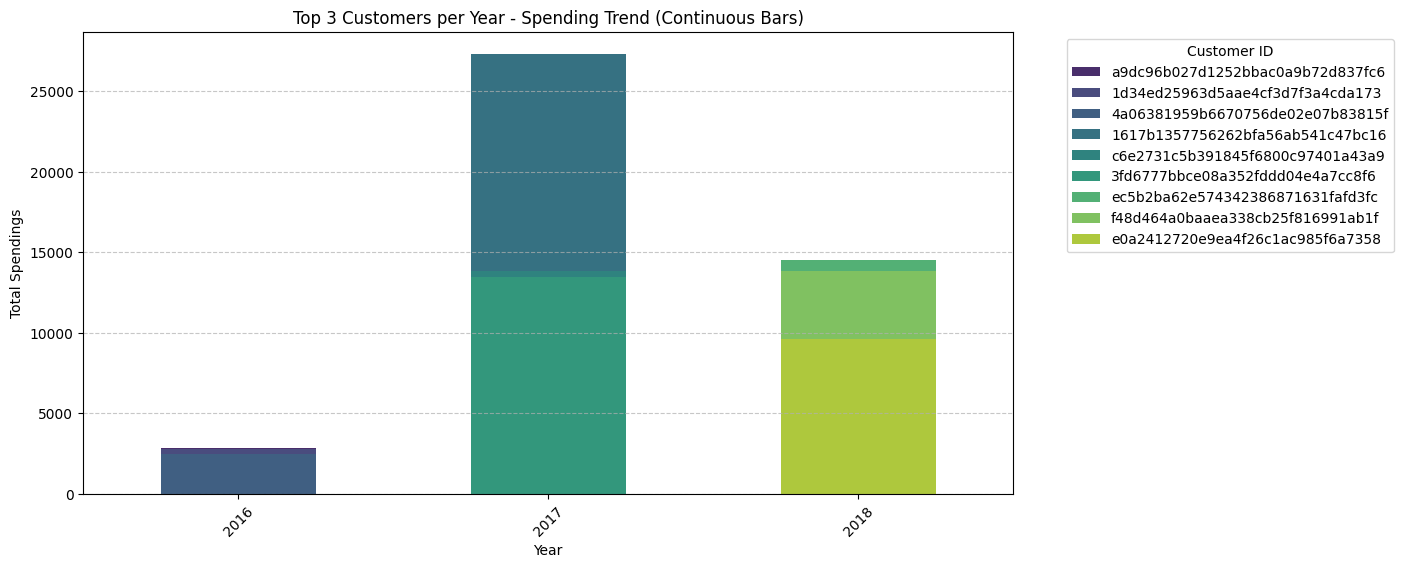

In [17]:

query = """ WITH customer_spending as
(
SELECT c.customer_id, year(o.order_purchase_timestamp) as order_year,
sum(p.payment_value) as total_spendings
FROM customers c
JOIN orders o 
ON c.customer_id = o.customer_id
JOIN payments p
ON o.order_id = p.order_id
GROUP BY 1,2
ORDER BY 3 DESC
),
ranked_customer AS
(
SELECT customer_id, order_year, total_spendings,
DENSE_RANK() OVER(PARTITION BY order_year ORDER BY total_spendings DESC) as Rank1
FROM customer_spending
)
SELECT * 
FROM ranked_customer
WHERE Rank1 <4;"""

cur.execute(query) 
data = cur.fetchall()

year_wise_top_spendings = pd.DataFrame(data, columns=['customer_id','order_year','total_spendings','Rank'])
year_wise_top_spendings


plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=year_wise_top_spendings, 
    x="order_year", 
    y="total_spendings", 
    hue="customer_id", 
    palette="viridis", 
    dodge=False,  # Removes gaps between bars
    width=0.5  # Makes bars thicker
)

# Customization
plt.xlabel("Year")
plt.ylabel("Total Spendings")
plt.title("Top 3 Customers per Year - Spending Trend (Continuous Bars)")
plt.legend(title="Customer ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()